# Capstone Project:  Face Shape Classification - Part 7

This notebook loads the model to predict on new data, and saves the model for web interface.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [2]:
!pip install mtcnn
import mtcnn
from mtcnn.mtcnn import MTCNN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.0 MB/s eta 0:00:00


In [ ]:
# -*- coding: utf-8 -*-
"""face_shape_classification_pytorch.py

This script loads a PyTorch model to predict face shapes and process images.
"""


# Define the dictionary for face shape labels
y_label_dict = {0: 'Heart', 1: 'Oblong', 2: 'Oval', 3: 'Round', 4: 'Square'}

# Initialize the MTCNN detector
detector = MTCNN()

def crop_and_resize(image, target_w=224, target_h=224):
    '''This function crops & resizes images to target size by keeping aspect ratio'''
    if image.ndim == 2:
        img_h, img_w = image.shape             # for Grayscale will be img_h, img_w = img.shape
    elif image.ndim == 3:
        img_h, img_w, channels = image.shape   # for RGB will be img_h, img_w, channels = img.shape
    target_aspect_ratio = target_w/target_h
    input_aspect_ratio = img_w/img_h

    if input_aspect_ratio > target_aspect_ratio:
        resize_w = int(input_aspect_ratio*target_h)
        resize_h = target_h
        img = cv2.resize(image, (resize_w , resize_h))
        crop_left = int((resize_w - target_w)/2)  ## crop left/right equally
        crop_right = crop_left + target_w
        new_img = img[:, crop_left:crop_right]
    if input_aspect_ratio < target_aspect_ratio:
        resize_w = target_w
        resize_h = int(target_w/input_aspect_ratio)
        img = cv2.resize(image, (resize_w , resize_h))
        crop_top = int((resize_h - target_h)/4)   ## crop the top by 1/4 and bottom by 3/4 -- can be changed
        crop_bottom = crop_top + target_h
        new_img = img[crop_top:crop_bottom, :]
    if input_aspect_ratio == target_aspect_ratio:
        new_img = cv2.resize(image, (target_w, target_h))

    return new_img

def extract_face(img, target_size=(224, 224)):
    '''This function extracts the face from images by:
    1) Finding the facial bounding box
    2) Slightly expanding top & bottom boundaries to include the whole face
    3) Cropping into a square shape
    4) Resizing to target image size for modeling
    5) If the facial bounding box is not found, image will be cropped & resized to 224x224 square'''

    # 1. detect faces in an image
    results = detector.detect_faces(img)
    if results == []:    # if face is not detected, call function to crop & resize by keeping aspect ratio
        new_face = crop_and_resize(img, target_w=224, target_h=224)
    else:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1+width, y1+height
        face = img[y1:y2, x1:x2]  # this is the face image from the bounding box before expanding bbox

        # 2. expand the top & bottom of bounding box by 10 pixels to ensure it captures the whole face
        adj_h = 10

        # assign value of new y1
        if y1-adj_h < 10:
            new_y1 = 0
        else:
            new_y1 = y1-adj_h

        # assign value of new y2
        if y1+height+adj_h < img.shape[0]:
            new_y2 = y1+height+adj_h
        else:
            new_y2 = img.shape[0]
        new_height = new_y2 - new_y1

        # 3. crop the image to a square image by setting the width = new_height and expand the box to new width
        adj_w = int((new_height-width)/2)

        # assign value of new x1
        if x1-adj_w < 0:
            new_x1 = 0
        else:
            new_x1 = x1-adj_w

        # assign value of new x2
        if x2+adj_w > img.shape[1]:
            new_x2 = img.shape[1]
        else:
            new_x2 = x2+adj_w
        new_face = img[new_y1:new_y2, new_x1:new_x2]  # face-cropped square image based on original resolution

    # 4. resize image to the target pixel size
    sqr_img = cv2.resize(new_face, target_size)
    return sqr_img

# Define the VGG16-Face model architecture in PyTorch
class VGG16Face(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG16Face, self).__init__()
        # Base model with features and classifier
        self.base_model = nn.Module()

        # Create features module
        self.base_model.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Classification layers
        self.base_model.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.base_model.features(x)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = self.base_model.classifier(x)
        return x



# Modified function to handle existing state dict structure
def load_model(model_path, strict=False):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = VGG16Face(num_classes=5)

    # Load the state dict and apply it to the model
    state_dict = torch.load(model_path, map_location=device)

    # Remove the mismatched keys from the state dict
    # The keys to remove are related to the final classifier layer
    state_dict = {k: v for k, v in state_dict.items() if 'classifier.6' not in k}

    # Print keys to debug
    print("Model state dict keys:")
    for key in list(state_dict.keys())[:5]:  # Print first 5 keys
        print(f"- {key}")

    # Load the modified state dict
    model.load_state_dict(state_dict, strict=strict) # strict=False to ignore missing keys

    model.to(device)
    model.eval()
    return model, device

# Alternative loading function for TensorFlow converted models
def convert_tf_to_pytorch(model_path):
    """
    Creates a PyTorch model from a TensorFlow saved model
    """
    import tensorflow as tf

    # Load the TensorFlow model
    tf_model = tf.keras.models.load_model(model_path)

    # Create the PyTorch model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    pt_model = VGG16Face(num_classes=5).to(device)

    # Transfer weights manually
    # This is a simplified example - you need to map TF to PyTorch layers correctly

    # Extract TensorFlow weights
    tf_weights = []
    for layer in tf_model.layers:
        weights = layer.get_weights()
        if weights:
            tf_weights.append(weights)

    # Set PyTorch weights
    # This requires careful mapping between the architectures
    # Example for conv layers:
    # pt_model.base_model.features[0].weight.data = torch.from_numpy(tf_weights[0][0].transpose(3, 2, 0, 1))
    # pt_model.base_model.features[0].bias.data = torch.from_numpy(tf_weights[0][1])

    # Save the converted model
    torch.save(pt_model.state_dict(), model_path.replace('.h5', '.pth'))

    return pt_model, device

# Define the image transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_face_shape(img_array, model, device):
    '''
    This function reads a single image in the form of an array,
    processes the image then makes predictions.
    '''
    try:
        # First extract the face using bounding box
        face_img = extract_face(img_array)  # Call function to extract face with bounding box
        new_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)  # Convert to RGB -- use this for display

        # Convert the image for modeling
        input_img = transform(new_img).unsqueeze(0)  # Add batch dimension
        input_img = input_img.to(device)

        # Make predictions
        with torch.no_grad():
            output = model(input_img)
            probabilities = F.softmax(output, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0][predicted_class].item()

        shape = y_label_dict[predicted_class]
        print(f'Your face shape is {shape}')
        print(f'Probability {np.around(confidence*100, 2)}%')

        plt.imshow(new_img)
        return shape, confidence, new_img

    except Exception as e:
        print(f'Oops! Something went wrong: {e}. Please try again.')
        return None, None, None

# Alternative preprocessing to match TensorFlow
def preprocess_image_tf_style(img):
    """
    Preprocess image to match TensorFlow's style
    """
    if img.shape[2] == 4:  # If image has alpha channel
        img = img[:, :, :3]

    # Resize
    img = cv2.resize(img, (224, 224))

    # Convert to float and scale to [0, 1]
    img = img.astype(np.float32) / 255.0

    # Reshape to batch format
    img = np.expand_dims(img, axis=0)

    return img

def predict_with_tf_style(img_array, model, device):
    """
    For use with TensorFlow-style preprocessing
    """
    try:
        # First extract the face using bounding box
        face_img = extract_face(img_array)  # Call function to extract face with bounding box
        new_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)  # Convert to RGB -- use this for display

        # Convert the image for modeling - TensorFlow style
        img_tensor = torch.from_numpy(preprocess_image_tf_style(new_img)).permute(0, 3, 1, 2)
        img_tensor = img_tensor.to(device)

        # Make predictions
        with torch.no_grad():
            output = model(img_tensor)
            probabilities = F.softmax(output, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0][predicted_class].item()

        shape = y_label_dict[predicted_class]
        print(f'Your face shape is {shape}')
        print(f'Probability {np.around(confidence*100, 2)}%')

        plt.imshow(new_img)
        return shape, confidence, new_img

    except Exception as e:
        print(f'Oops! Something went wrong: {e}. Please try again.')
        return None, None, None

# Example usage:
# Option 1: Direct load from PyTorch model
model, device = load_model("/content/drive/MyDrive/CV Project/save models/vgg16_face_transfer_final.pth", strict=False)



Model state dict keys:
- base_model.features.0.weight
- base_model.features.0.bias
- base_model.features.2.weight
- base_model.features.2.bias
- base_model.features.5.weight


# Predictions

Your face shape is Oval
Probability 22.38%


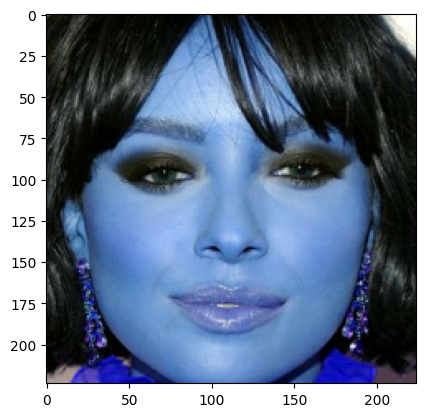

In [6]:

# Read an image
img = cv2.imread("/content/heart (5).jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for MTCNN

# Predict face shape
shape, confidence, processed_img = predict_face_shape(img_rgb, model, device)